In [1]:
#==========================
#necessary packages 
#(matplotlib, numpy and scipy)
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import math
from scipy.special import erf
#==========================


#==========================
#below came along with the notebook
import motif_displacement_analysis_package as mdap
from motif_displacement_analysis_package import load
from motif_displacement_analysis_package import motif_scanning



# Motif Displacement Analysis

In [16]:
%matplotlib inline

#==============================================
#Choose the MD score file from MD_score_files/
#note just denote with the SRR identifier
#consulation excel conditionals_table
#for details
#==============================================

#Add N=1 to motif displacement plots

FILE1="ERR769522_1"


D1   = load.motif_displacements_raw("/Users/joazofeifa/Lab/new_motif_distances/motif_hits_human_3/"+FILE1 + "_enrichment_stats.tsv")


#================
#From MD score file SRR1105737, NRF1_HUMAN.H10MO.A shows apparent co-occurrence with BTEs
#make save fig available to user


motif_model1 = 'NRF1_HUMAN.H10MO.A' #apparent co-occurrence with BTEs
motif_model2 = 'TYY1_HUMAN.H10MO.A' #apparent bimodal co-occurrence with BTEs
motif_model3 = 'SCRT2_HUMAN.H10MO.D'#little co-occurrence with BTEs
motif_model4 = 'HXB3_HUMAN.H10MO.D' #apparent depletion at BTEs
motif_model5 = "P53_HUMAN.H10MO.B"



load.show_motif_displacement(D1, motif_model2)



ValueError: could not convert string to float: Non

# The Motif Displacement Score

An MD score relates the proportion of significant motif sites within some window h divided by the total number of motifs against some larger window H centered at all BTE events. Let $X_j=\{x_1,x_2,...,x_n\}$ be the set of BTE locations genome wide for some experiment $j$. Let $Y_i=\{y_1,y_2,...,y_n\}$ be the set of all significant motif sites for some TF-DNA binding motif model $i$ genome wide, this is static and only depends on the genome build of interest. Therefore the the MD scores is calculated by the below equation.

\begin{align}
g(X_j, Y_i;a)&= \sum_{x\in X_j}\sum_{y\in Y_i }\delta (|x-y|< a)\\
md_{j,i}    &= g(X_j, Y_i; h)/g(X_j, Y_i; H)
\end{align}

Here $\delta(.)$ is a simple indicator function that returns one if the condition (.) evaluates true otherwise to zero. If yi and xi are uniformly distributed throughout the genome, i.e. following a homogenous poisson point process, then $g(X_j,Y_i;h)$ is distributed as a binomial distribution with parameters $p,N$ where $p=h/H$ and $N=g(X_j,Y_i;H)$ where $h\leq H$. In cases where $g(H)\gg 0$, the binomial is well approximated by a Gaussian distribution and hypothesis testing under some α level can proceed in the normal fashion. In brief, significantly increased MD scores (by a binomial test) is diagnostic of heightened motif frequency surrounding BTE locations.The MD score constitutes a proportion and as mentioned as long as h is upper bounded by H then mdj,i will always exist within $[0,1]$



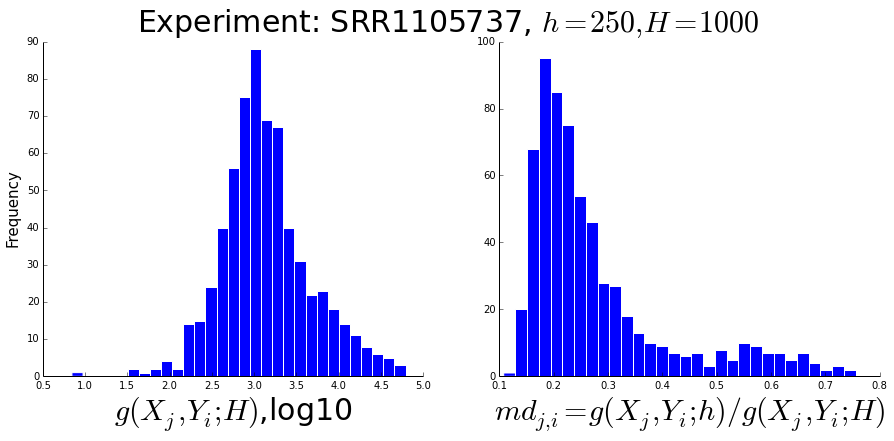

In [3]:
%matplotlib inline

#=======================================================================================
#Show the distribution of MD scores for some experiment in MD_scores/
#=======================================================================================

#==================

FILE1="SRR1105737" #change accordingly!

#==================


D1   = load.MD_score_file("data_azofeifa_2016/MD_score_files/"+FILE1 + "_enrichment_stats.tsv")

F    = plt.figure(figsize=(15,6))
ax1  = F.add_subplot(1,2,1)
ax2  = F.add_subplot(1,2,2)

TYPE = 2
ax1.hist([ math.log(D1[motif][0][TYPE],10)  for motif in D1 if D1[motif][0][TYPE] ], 
         edgecolor="white",color="blue",bins=30)
ax2.hist([ D1[motif][1][TYPE]  for motif in D1 ], 
         edgecolor="white",color="blue",bins=30)

ax1.set_ylabel("Frequency",fontsize=15)
ax1.set_xlabel(r"$g(X_j,Y_i;H)$"+",log10",fontsize=30)
ax2.set_xlabel(r"$md_{j,i}=g(X_j,Y_i;h)/g(X_j,Y_i;H)$",fontsize=30)
for ax in (ax1,ax2):
    load.despine(ax)
F.suptitle("Experiment: " + FILE1 + ", " r"$h=250, H=1000$",fontsize=30)
plt.plot()

load.despine(ax)




## Synthetic Sequenc Simulation

Although theoretically correct, motifs are not distributed uniformly throughout the genome. And specifically they will not be distributed uniformly when conditioning on the center of a BTE around some window of size $H$ given the non-stationarity of the GC content. In this way, a binomial test which assumes a homogenous poisson process of motif locations genome wide may be a too liberal null model or background assumption. To control for this non-stationarity, we propose a simulation based method to compute more appropriate p-values for a significant MD score under an empirical CDF. Let $L$ be an $4x2H$ matrix where each column corresponds to a position from a BTE and each row corresponds to a probability distribution over the DNA alphabet $\{A,T,G,C\}$. 


To be clear, $L[0,0]$ corresponds to the probability of an A at position $-H$ from any BTE,similarily $L[2,1000]$ corresponds to the probability that a G occurs at exactly the point of the BTE.  Therefore, the simulation based method of the background model is simple. Given an experiment of $X_j$ BTE locations, we simulate $|X_j|$ sequences following this non-stationary GC content bias. We then iterate over all 641 TF DNA PSSM models and look for significant motif. 

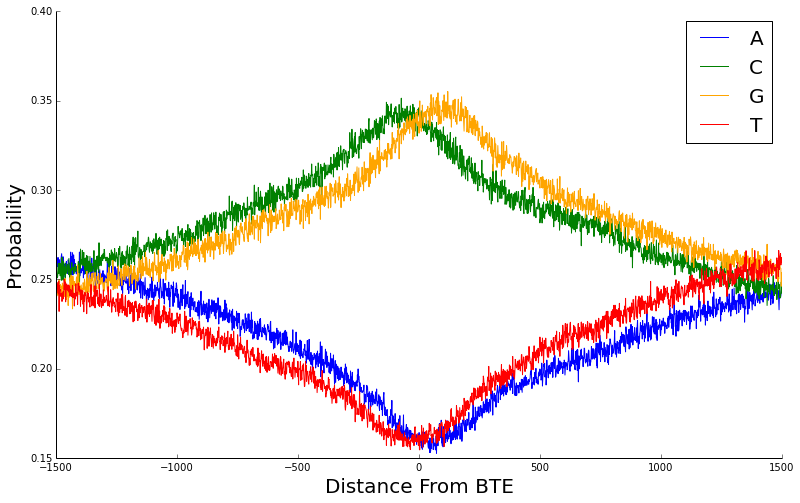

In [4]:
#plot the nucleotide frequency as a function of BTE location
simulation_motif_database="data_azofeifa_2016/motif_simulations_DB.txt"

L=load.gc_content_from_simulated_DB(simulation_motif_database)

%matplotlib inline
colors 	= "blue", "green", "orange", "red"
labels 	= "A", "C", "G", "T"
F = plt.figure(figsize=(13,8))
ax=plt.gca()
for k in range(4):
    ax.plot(np.linspace(-1500,1500, len(L)),[x[k] for x in L], lw=1, color=colors[k], label=labels[k] )
ax.legend(loc="best",fontsize=20)
ax.set_xlabel("Distance From BTE",fontsize=20)
ax.set_ylabel("Probability",fontsize=20)
load.despine(ax)
plt.show()

With this in hand it is absolutely straightforward to compute any summary statistics about the displacement of the motif relative to these synthetic sequences and in particular we will compute $MD=\{md_1,md_2,...,md_{641}\}$. It should be noted that any motif match is by complete chance alone. We iterate this process 10,000 times to compute a empiracle CDF $F_{n}(md_i)$ over $md_i$ and thus we can assess the probability of our observed mdi relative to our empirically simulated.

In [5]:
#method to simulate a random sequence from the order mutlinomial distribution above
def make_a_random_sequence(L):
    ALPHABET = {0:"A", 1:"C",2: "G", 3:"T"}
    seq      = ""
    for i in range(len(L)):
        S,j,u    = L[i][0],1,np.random.uniform(0,1)
        while u > S and j < 4: #CDF method
            S+=L[i][j]
            j+=1
        seq+=ALPHABET[j-1]
    return seq

print "simulated sequence middle 10%"
print
print make_a_random_sequence(L[900:1100])

simulated sequence middle 10%

GCAACCGCATACCCTCGGACCTCCATTACCTGGAGGACCGCACAATTCAACATTGAGACTAAACCGTTCGAACCGCAGGAACTTACGGCCGCGTATGTAGCTTCAGACTGGCGGCCGTGAGCATCGTGTGCTGAACAATCCGTGCCGGGACCCGTTTTACGGCGGCCCCTGTATGGCTCGGCCCCATTCCCATCGCATTT


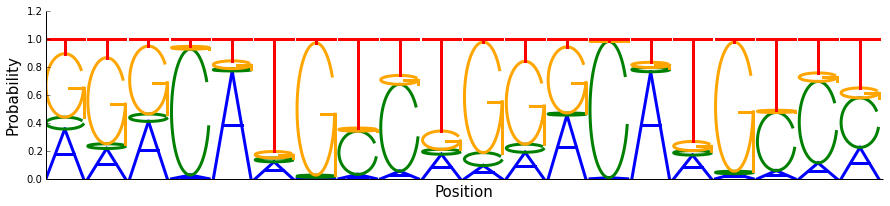

In [6]:
#display PSSM from DB
reload(motif_scanning )

#==========================
#change accordingly
motif          = 'P53_HUMAN.H10MO.B'
#==========================


P,D            = load.PSSM_and_simulated_draws("data_azofeifa_2016/motif_simulations_DB.txt")
weight_matrix  = np.array(P[motif]) #this is a numpy matrix

#=================================
#PSSM CLASS!!
pssm_model     = motif_scanning.PSSM(weight_matrix,pval_threshold=pow(10,-3))
#=================================



#do the plotting
%matplotlib inline
F      = plt.figure(figsize=(15,3))
ax     = plt.gca()

pssm_model.draw_logo(ax=ax)


Motif scanning amounts to computing a likelihood ratio between the PSSM model $M$ and some background model $B$. If $S=\{s_{0},s_{1},...,s_{n}\}$ is an ordered set of nuleotides then the log-likelihood of $S$ under $M$ and $B$ are given below.

\begin{align}
L_M(S)&= \sum_i\log ( M ( i , s_i ) )\\
L_B(S)&= \sum_i\log (B(s_i))
\end{align}

where $M$ is a $m$ by $4$ matrix that encodes the probability of observing nucleotide $j$ at position $i$. 

\begin{equation}
M=
\begin{bmatrix}
p_{1,a} & p_{1,c}& p_{1,g}& p_{1,t}\\
\vdots &\vdots  &\vdots  &\vdots  \\
p_{m,a} & p_{m,c}& p_{m,g}& p_{m,t}\\
\end{bmatrix}
\end{equation}

And $B$ is a vector of probabilities of observing nucleotide $j$ independent of position.

\begin{equation}
B=
\begin{bmatrix}
p_{a} & p_{c} & p_{g} & p_{t}  \\
\end{bmatrix}
\end{equation}

Our test statistic is $LLR$ defined $2*(L_M(S)-L_B(S))$. To perform hypothesis testing requires knowledge of how $LLR$ is distributed. It is easy to see that there exist $4^{m}$ unique sequences and thus potentially $4^m$ possible $LLR$ computations. To work around the exponential explosition, we use the popular binning dynamic programming algorithm outlined below. 












In [7]:
#==============================================
#compute binned likelihood null distribution
#necessary to perform subsequent scanning
#on random sequences
#p-value < 10^-3 is for demonstrative perposes
#only, in the Azofeifa, 2017 paper this was 
#set to 10^-6
#==============================================


pssm_model.compute_binned_llr_distribution()



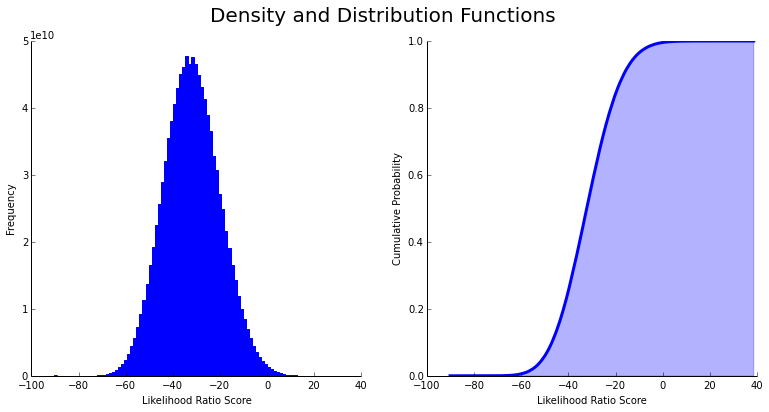

In [8]:
#==============================================
#Display Null Distribution
#==============================================

%matplotlib inline

F  = plt.figure(figsize=(13,6))
F.suptitle("Density and Distribution Functions " + pssm_model.name,fontsize=20)
ax1= F.add_subplot(1,2,1)
ax1.hist(pssm_model.ePDF[:,0], weights=pssm_model.ePDF[:,1],bins=100,edgecolor ="blue",color ="blue")        
ax2= F.add_subplot(1,2,2)
ax2.plot(pssm_model.eCDF[:,0], pssm_model.eCDF[:,1],lw=3 )
ax2.fill_between(pssm_model.eCDF[:,0], np.zeros((len(pssm_model.eCDF,))), pssm_model.eCDF[:,1],color="blue",alpha=0.3 )
for ax in (ax1,ax2):
    load.despine(ax)
    ax.set_xlabel("Likelihood Ratio Score")
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Cumulative Probability")
plt.show()

10.795604 seconds to run 100 sequences


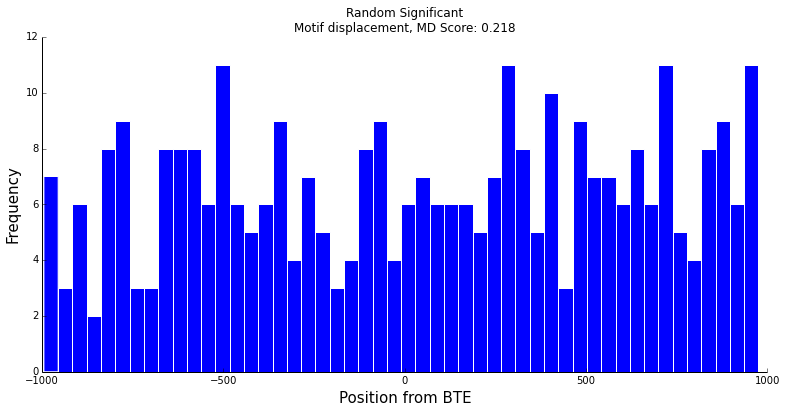

In [9]:
%matplotlib inline
import time
def compute_MD_score(positions, h):
    return sum([1 for x in positions if abs(x - 1000) < h ])/float(len(positions))
N,positions=100,list()
start=time.clock()
for i in range(N):
    seq = make_a_random_sequence(L)
    positions+=pssm_model.scan(seq)
print time.clock()-start,"seconds to run",N,"sequences"

#do some plotting
F=plt.figure(figsize=(13,6))
ax=plt.gca()
rand_MD_score=compute_MD_score(positions,250)
ax.set_title("Random Significant\nMotif displacement, MD Score: " + str(rand_MD_score )[:5])
ax.hist([x-1000 for x in positions],bins=50,edgecolor="white")
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xlabel("Position from BTE",fontsize=15)
load.despine(ax)
plt.show()




It is easy to see that this analysis is computationally time consuming. To speed things up, this algorithm was rewritten in the C++ programming language with openMPI parrallel processing to run across multicore, multinode compute clusters. With this in hand, we compute over 10 million sequences following the GC content. 

Last but not least, we chose a simulation based approach rather than a position varying background model because it is unclear whether a  position varying background model would correct for the nucleotide non-stationarity to an extent that we could then assume a binomial model. At the very leat, future work in motif scanning and modeling should take into consideration the underlying neclotide frequencies as stationarity, in general, can not be assumed. 

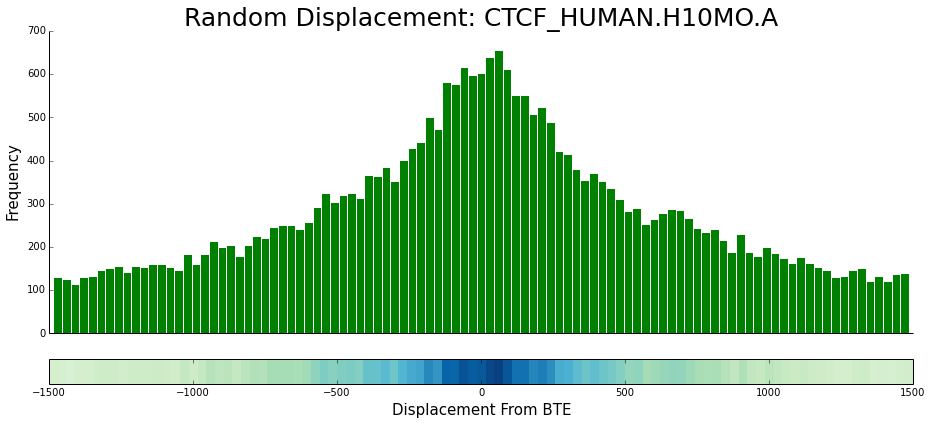

In [13]:
%matplotlib inline
reload(load)
P,D  = load.PSSM_and_simulated_draws("data_azofeifa_2016/motif_simulations_DB.txt")

motif_model1 = 'HXB3_HUMAN.H10MO.D'
motif_model2 = 'NRF1_HUMAN.H10MO.A'
motif_model3 = 'TYY1_HUMAN.H10MO.A'
motif_model4 = 'CTCF_HUMAN.H10MO.A'


load.show_motif_displacement(D, motif_model4,title="Random Displacement: ")




In [ ]:
#===================================================================================
#With a data set of N bidirectional, N random, synthetic sequences are generated 
#15,000 times. For each group of N, we compute an MD score. Below is the distribution of MD
#scores for a specific motif, under a  specific dataset
#===================================================================================

FILE1      ="SRR1105737"
D1         = load.load_motif_displacements_background_MD("data_azofeifa_2016/MD_score_files/"
                                                         +FILE1 + "_enrichment_stats.tsv")

motif_model="CTCF_HUMAN.H10MO.A"

F          = plt.figure(figsize=(15,6))
ax         = plt.gca()
ax.set_title(motif_model,fontsize=15)
ax.hist(D1[motif_model],bins=30,edgecolor="white")
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xlabel("Random MD Score",fontsize=15)

load.despine(ax)
plt.show()


In [ ]:
#=================================================
#Plot the expected value of the random MD score
#against the observed MD score in a single dataset
#=================================================

reload(load)


FILE1      ="SRR1105737"

D1=load.get_obs_and_rand("data_azofeifa_2016/MD_score_files/"+
                         FILE1 + "_enrichment_stats.tsv")


F =plt.figure(figsize=(13,6))
ax=plt.gca()
ax.scatter([D1[motif][1][0] for motif in D1],[D1[motif][0][2] for motif in D1],
          edgecolor="blue",color="blue",alpha=0.4)
ax.plot([0.1,0.5],[0.1,0.5],ls="--",color="green",lw=3.,
       label="y=x, line")
ax.legend(loc="best")
ax.set_xlabel("Null Expectation of MD Score",fontsize=25)
ax.set_ylabel("Observed MD Score\n("+ FILE1+ ")",fontsize=25)
ax.grid()
load.despine(ax)
plt.show()



# Differential MD Score Analysis


An important question is whether this MD score as significantly shifted between two experiments j,k as a function of Xj and Xk. This analysis is straightforward under the two proportion z-test. Specifically we are testing the null and alternative hypothesis tests.
\begin{align}
H_0:& md_{j,i}=md_{k,i}\\
H_1:& md_{j,i}\neq md_{k,i}
\end{align}

We let the pooled sample proportion be given by the first statement in the below equation  and the standard error be the second statement. Therefore our test statistic $z$ is normally distributed with mean 0 and variance 1. 

\begin{align}
p_i&=\frac{(md_{j,i}\cdot g(X_j,Y_i; H) +md_{k,i}\cdot g(X_k,Y_i; H) )}{g(X_j,Y_i; H) + g(X_k,Y_i; H)} \\
SE&=\frac{p(1-p)}{(1/g(X_j,Y_i; H) + 1/g(X_k,Y_i; H))} \\
\end{align}

\begin{equation}
z=\frac{md_{j,i}-md_{k,i}}{\sqrt{SE}}\sim N(0,1)
\end{equation}

Thus p-value computation of changes in the MD score for some TF DNA binding model $i$ between two experiments $j$ and $k$ can be assessed in the normal fashion under some $\alpha$ level. In all comparisons throughout we utilize a Bonferroni multiple hypothesis correction to compute an adjusted $\alpha$ level i.e. $\alpha_{new} = \frac{\alpha}{641}$.




In [ ]:
#===============================================
#Use differential_MD module

import motif_displacement_analysis_package
from motif_displacement_analysis_package import differential_MD
reload(differential_MD)
#===============================================




In [ ]:
#===============================
#(Nutlin Experiment, Allen 2014)

#=============================================
#Load MD scores to be compared 

FILE1="SRR1105737" #DMSO Untread

FILE3="SRR1105739" #Nutlin Treatment

#=============================================
#append file extenstions and paths
AP    = "_enrichment_stats.tsv"
MD_DIR="data_azofeifa_2016/MD_score_files/"





MDS    = differential_MD.mds_frame()
#=============================================
#First argument is a list of strings with size > 0
#Second argument is a unique identifier (string)


MDS.load_MD_score_file( [ MD_DIR+FILE1+AP ] , "HCT116 DMSO")
MDS.load_MD_score_file( [ MD_DIR+FILE3+AP ] , "HCT116 Nutlin")





# %matplotlib inline
# pvals, differences, centers = plot_MD_score_changes(D1, D2,threshold=pow(10,-6),title="(Allen, 2014)")

In [ ]:
#==============================================
#Plot changes in MD score

pval_threshold=pow(10,-5)


%matplotlib inline
MDS.differential_single("HCT116 DMSO", "HCT116 Nutlin",pval_threshold=pval_threshold, ax=None, OUT="")

In [ ]:
#===============================
#Combind Replications!

FILE1="SRR1105737" #DMSO Untread, rep1
FILE2="SRR1105736" #DMSO Untread, rep2

FILE3="SRR1105738" #Nutlin Treatment, rep1
FILE4="SRR1105739" #Nutlin Treatment, rep2

#=============================================
#append file extenstions and paths
AP    = "_enrichment_stats.tsv"
MD_DIR="data_azofeifa_2016/MD_score_files/"





MDSr    = differential_MD.mds_frame()
#=============================================
#First argument is a list of strings with size > 0
#Second argument is a unique identifier (string)


MDSr.load_MD_score_file( [ MD_DIR+FILE1+AP, MD_DIR+FILE2+AP  ] , "HCT116 DMSO")
MDSr.load_MD_score_file( [ MD_DIR+FILE3+AP, MD_DIR+FILE4+AP ] , "HCT116 Nutlin")





In [ ]:
#==============================================
#Plot changes in MD score, replicates in account
#sort by MD score print out statement or p-value
pval_threshold=pow(10,-8)

%matplotlib inline
MDSr.differential_single("HCT116 DMSO", "HCT116 Nutlin",pval_threshold=pval_threshold, ax=None, OUT="")

In [ ]:
#some other interesting experiments
#===============================
#(TNF-alpha Experiment, Luo 2014)

FILE1="SRR1015583" #Vehicle
FILE2="SRR1015587" #TNF-alpha  (10 min)

#===============================
#(Estradiol Experiment, Hah 2013)
FILE1="SRR497908" #Vehicle
FILE2="SRR653425" #Estradiol  (1hr)


#========================================================
#Perform Differential Analysis on Replicates
#(Hah, 2013)

MDS    = differential_MD.mds_frame()

MDS.load_MD_score_file([MD_DIR+FILE1+AP], "Rep1" )
MDS.load_MD_score_file([MD_DIR+FILE2+AP], "Rep2" )


%matplotlib inline
MDS.differential_single("Rep1", "Rep2",pval_threshold=pow(10,-10))




In [ ]:
def add(b,a=MD_DIR , c="_enrichment_stats.tsv"):
    return a+b+c


#========================================================
#Perform Differential Over Time!
#Luo 2014 TNF-alpha

reload(differential_MD)

MDS2     = differential_MD.mds_frame()    
MDS2.load_MD_score_file(map(add,["SRR1015583","SRR1015584"]), "AC16 DMSO")
MDS2.load_MD_score_file(map(add,["SRR1015585","SRR1015586"]), "AC16 TNFalpha(10m)")
MDS2.load_MD_score_file(map(add,["SRR1015587","SRR1015588"]), "AC16 TNFalpha(30m)")
MDS2.load_MD_score_file(map(add,["SRR1015589","SRR1015590"]), "AC16 TNFalpha(1hr)")



In [ ]:
#=========================================================
#1st argument list of groups to compare (order matters)
SMOOTH= True
FILTER= True
DT    = True
PT    = pow(10,-5) #relevant only if filter_static is on

%matplotlib inline
MDS2.differential_multiple([ "AC16 DMSO",
                           "AC16 TNFalpha(10m)", "AC16 TNFalpha(30m)",
                           "AC16 TNFalpha(1hr)", ],smooth=SMOOTH,filter_static=FILTER,pval_threshold=PT,dt=DT)


In [ ]:
#========================================================
#Perform Differential Over Time!
#KLA Treatment TNF-alpha

MD_DIR="/Users/joazofeifa/Lab/new_motif_distances/motif_hits_mouse/" #now you need to download the bigger dataset from !

def add(b,a=MD_DIR , c="_enrichment_stats.tsv"):
    return a+b+c

MDS3     = differential_MD.mds_frame()    
MDS3.load_MD_score_file(map(add,["SRR930691", "SRR930692", "SRR930693", "SRR930694","SRR930684"]), "KLA_DMSO")
MDS3.load_MD_score_file(map(add,["SRR930670"]), "KLA_10min") 
MDS3.load_MD_score_file(map(add,["SRR930671", "SRR930659","SRR930660","SRR930661","SRR930662"]), "KLA_1hr") 
MDS3.load_MD_score_file(map(add,["SRR930672", "SRR930663","SRR930664"]), "KLA_6hr") 
MDS3.load_MD_score_file(map(add,["SRR930673", "SRR930665","SRR930666"]), "KLA_12hr") 
MDS3.load_MD_score_file(map(add,["SRR930674", "SRR930667","SRR930668"]), "KLA_24hr") 


MDS3.differential_multiple(["KLA_DMSO","KLA_10min", 
    "KLA_1hr","KLA_6hr","KLA_12hr","KLA_24hr"  ],smooth=True,filter_static=True,pval_threshold=pow(10,-10),dt=True)




In [ ]:
#========================================================
#MD score changes across tissue type and differentiation
#Wang 2015
#========================================================
MD_DIR="/Users/joazofeifa/Lab/new_motif_distances/motif_hits_human_2/"
def add(b,a=MD_DIR , c="_enrichment_stats.tsv"):
    return a+b+c

MDS4     = differential_MD.mds_frame()    

MDS4.load_MD_score_file(map(add, ["SRR1145801"]), "D0"  )
MDS4.load_MD_score_file(map(add, ["SRR1145808"]), "D2"  )
MDS4.load_MD_score_file(map(add, ["SRR1145815"]), "D5"  )
MDS4.load_MD_score_file(map(add, ["SRR1145822"]), "D7"  )
MDS4.load_MD_score_file(map(add, ["SRR1145829"]), "D10"  )


MDS4.differential_multiple(["D0","D2", 
    "D5","D7","D10"],smooth=True,filter_static=True,pval_threshold=pow(10,-15),dt=True)






